In [1]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklego.linear_model import LowessRegression

### Reading in from external source

In [2]:
geo = "GSE24709"
data = GEOparse.get_GEO(geo=geo, destdir="../Dataset/Leidinger2011", silent=True)
#table = pd.read_csv("../Dataset/Fehlman2020/expression_matrix.csv", sep="\t")
#table = pd.read_csv("../Dataset/Wozniak2015/GSE64591_non-normalized.txt", sep="\t", header=5)

In [3]:
table = pd.concat((val.table.iloc[:,1:] for val in data.gsms.values()), axis=1).transpose()
mirnas = list(data.gsms.values())[0].table.iloc[:,0]

In [4]:
table

,0,1,2,3,4,5,6,7,8,9,...,853,854,855,856,857,858,859,860,861,862
VALUE,903.359155,760.950704,674.176056,367.605634,16.507042,47.352113,101.070423,1.000000,1.000000,87.690141,...,3982.566901,123.380282,5567.345070,187.267606,116.845070,78.985915,32.816901,60.760563,159.380282,227.661972
VALUE,1329.408451,528.338028,1182.584507,218.338028,14.873239,14.873239,126.816901,14.873239,14.873239,79.887324,...,3708.204225,79.887324,5079.535211,180.112676,79.887324,112.676056,79.887324,62.253521,14.873239,278.140845
VALUE,3887.415493,1040.383803,458.901409,25.521127,25.521127,25.521127,227.661972,25.521127,78.873239,113.352113,...,7269.838028,25.521127,358.478873,325.521127,212.676056,125.746479,25.521127,113.352113,25.521127,286.873239
VALUE,1860.767606,305.915493,1026.197183,123.950704,3.154930,46.422535,146.338028,14.478873,14.478873,3.154930,...,4284.021127,104.422535,8404.859155,198.591549,84.760563,58.450704,84.760563,3.154930,152.985916,161.746479
VALUE,2321.352113,308.788732,1470.084507,215.098591,19.943662,26.366197,120.507042,14.478873,1.000000,6.647887,...,2645.704225,80.394366,8897.661972,208.535211,107.211268,55.887324,49.577465,55.887324,156.788732,202.873239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALUE,1054.570423,163.718310,4077.718310,155.042253,36.225352,36.225352,141.690141,15.211268,49.380282,66.140845,...,1780.633803,516.056338,3548.352113,1.000000,20.845070,80.478873,86.929577,27.267606,360.169014,323.239437
VALUE,1932.366197,156.788732,3362.823944,114.084507,1.000000,1.000000,380.309859,1.000000,35.690141,1.000000,...,3548.352113,185.577465,2526.619718,89.211268,70.478873,89.211268,128.901409,61.014085,232.985916,170.929577
VALUE,782.478873,258.140845,2645.704225,166.929577,21.633803,59.915493,272.056338,59.915493,21.633803,36.535211,...,3079.133803,166.929577,4460.126761,111.549296,89.070423,100.507042,124.957746,74.366197,400.619718,229.690141
VALUE,408.788732,181.859155,539.661972,92.338028,1.000000,12.281690,163.098591,17.183099,1.000000,1.000000,...,4284.021127,200.732394,2969.676056,194.338028,148.197183,120.394366,148.197183,92.338028,506.704225,283.915493


### Seperate case and controls

In [5]:
meta = np.array([k.metadata["title"][0] for k in list(data.gsms.values())])

In [6]:
meta

array(['copd 1', 'copd 2', 'copd 3', 'copd 4', 'lung cancer 1', 'copd 5',
       'copd 6', 'copd 7', 'copd 8', 'copd 9', 'copd 10', 'copd 11',
       'copd 12', 'copd 13', 'copd 14', 'copd 15', 'copd 16', 'copd 17',
       'copd 18', 'copd 19', 'copd 20', 'copd 21', 'copd 22', 'copd 23',
       'copd 24', 'lung cancer 2', 'lung cancer 3', 'lung cancer 4',
       'normal 1', 'normal 2', 'lung cancer 5', 'lung cancer 6',
       'lung cancer 7', 'lung cancer 8', 'lung cancer 9',
       'lung cancer 10', 'lung cancer 11', 'lung cancer 12',
       'lung cancer 13', 'lung cancer 14', 'lung cancer 15',
       'lung cancer 16', 'lung cancer 17', 'lung cancer 18',
       'lung cancer 19', 'lung cancer 20', 'normal 3', 'lung cancer 21',
       'lung cancer 22', 'lung cancer 23', 'lung cancer 24',
       'lung cancer 25', 'lung cancer 26', 'lung cancer 27',
       'lung cancer 28', 'normal 4', 'normal 5', 'normal 6', 'normal 7',
       'normal 8', 'normal 9', 'normal 10', 'normal 11', 'normal 12'

In [7]:
sick = np.array(["lung" in k.metadata["title"][0] for k in list(data.gsms.values())])
controls = np.array(["normal" in k.metadata["title"][0] for k in list(data.gsms.values())])
mask = sick + controls
table = table.loc[mask]
sick = sick[mask]
controls = controls[mask]
meta = meta[mask]

In [8]:
sum(controls)

19

### Drop NAN

In [9]:
table = table.dropna(1)

C:\Users\olefr\AppData\Local\Temp/ipykernel_10192/1927661217.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  table = table.dropna(1)


### T-test

In [10]:
X = table

In [11]:
X

,0,1,2,3,4,5,6,7,8,9,...,853,854,855,856,857,858,859,860,861,862
VALUE,2321.352113,308.788732,1470.084507,215.098591,19.943662,26.366197,120.507042,14.478873,1.000000,6.647887,...,2645.704225,80.394366,8897.661972,208.535211,107.211268,55.887324,49.577465,55.887324,156.788732,202.873239
VALUE,754.295775,196.845070,2735.049296,104.225352,26.985915,1.000000,162.535211,3.690141,1.000000,26.985915,...,7107.397887,172.000000,6388.669014,108.788732,127.295775,92.619718,63.436620,16.338028,183.830986,139.943662
VALUE,717.450704,140.732394,3797.809859,86.535211,6.647887,21.859155,655.151409,1.000000,1.000000,16.957746,...,13651.436620,149.183099,4284.021127,55.887324,80.394366,16.957746,114.084507,76.112676,279.070423,98.422535
VALUE,1932.366197,165.633803,2645.704225,105.408451,46.422535,21.464789,228.000000,28.169014,1.000000,21.464789,...,10868.661970,176.732394,4284.021127,171.605634,113.521127,55.070423,72.253521,4.704225,240.563380,176.732394
VALUE,1494.492958,99.380282,4619.711268,73.464789,3.323944,37.661972,141.633803,18.478873,3.323944,37.661972,...,6634.781690,204.338028,5840.450704,185.943662,141.633803,37.661972,59.915493,37.661972,185.943662,141.633803
VALUE,1006.838028,174.929577,2321.352113,66.760563,31.042254,16.957746,196.394366,16.957746,1.000000,31.042254,...,5567.345070,196.394366,3548.352113,122.028169,79.887324,52.056338,79.887324,31.042254,256.957746,122.028169
VALUE,782.478873,260.619718,3362.823944,281.521127,77.690141,77.690141,99.830986,5.239437,5.239437,123.830986,...,3548.352113,123.830986,6634.781690,145.521127,99.830986,51.380282,51.380282,77.690141,166.028169,114.084507
VALUE,1518.901408,301.549296,4077.718310,395.915493,5.126761,147.830986,87.492958,87.492958,27.154930,27.154930,...,17071.739440,27.154930,6388.669014,118.309859,27.154930,87.492958,193.577465,60.901408,118.309859,358.478873
VALUE,1230.028169,224.394366,4284.021127,447.605634,170.647887,92.507042,143.718310,8.760563,117.126761,30.619718,...,3079.133803,170.647887,3708.204225,92.507042,92.507042,66.281690,143.718310,66.281690,170.647887,202.873239
VALUE,1244.859155,244.478873,2845.943662,342.309859,87.577465,44.169014,161.802817,107.887324,2.084507,68.563380,...,4284.021127,44.169014,7975.436620,87.577465,161.802817,17.802817,125.859155,87.577465,144.169014,244.478873


In [12]:
X_healthy, X_cancer = X[controls == 1], X[sick == 1]

In [13]:
results = ttest_ind(X_healthy, X_cancer).pvalue

In [14]:
lowest, pvalues = np.argsort(results)[:5], np.sort(results)[:5]

In [15]:
mirnas.iloc[lowest], pvalues

(512     hsa-miR-20b
 813    hsa-miR-106a
 20       hsa-miR-17
 251     hsa-miR-20a
 47      hsa-let-7d*
 Name: ID_REF, dtype: object,
 array([6.65446684e-09, 3.41690525e-08, 1.02838436e-07, 7.73639519e-07,
        1.15497101e-06]))

### F-test

In [16]:
t3 = table

In [17]:
f, p = f_classif(t3, sick)

In [18]:
np.mean(p)

0.27416953752268947

### ANOVA

In [19]:
t3

,0,1,2,3,4,5,6,7,8,9,...,853,854,855,856,857,858,859,860,861,862
VALUE,2321.352113,308.788732,1470.084507,215.098591,19.943662,26.366197,120.507042,14.478873,1.000000,6.647887,...,2645.704225,80.394366,8897.661972,208.535211,107.211268,55.887324,49.577465,55.887324,156.788732,202.873239
VALUE,754.295775,196.845070,2735.049296,104.225352,26.985915,1.000000,162.535211,3.690141,1.000000,26.985915,...,7107.397887,172.000000,6388.669014,108.788732,127.295775,92.619718,63.436620,16.338028,183.830986,139.943662
VALUE,717.450704,140.732394,3797.809859,86.535211,6.647887,21.859155,655.151409,1.000000,1.000000,16.957746,...,13651.436620,149.183099,4284.021127,55.887324,80.394366,16.957746,114.084507,76.112676,279.070423,98.422535
VALUE,1932.366197,165.633803,2645.704225,105.408451,46.422535,21.464789,228.000000,28.169014,1.000000,21.464789,...,10868.661970,176.732394,4284.021127,171.605634,113.521127,55.070423,72.253521,4.704225,240.563380,176.732394
VALUE,1494.492958,99.380282,4619.711268,73.464789,3.323944,37.661972,141.633803,18.478873,3.323944,37.661972,...,6634.781690,204.338028,5840.450704,185.943662,141.633803,37.661972,59.915493,37.661972,185.943662,141.633803
VALUE,1006.838028,174.929577,2321.352113,66.760563,31.042254,16.957746,196.394366,16.957746,1.000000,31.042254,...,5567.345070,196.394366,3548.352113,122.028169,79.887324,52.056338,79.887324,31.042254,256.957746,122.028169
VALUE,782.478873,260.619718,3362.823944,281.521127,77.690141,77.690141,99.830986,5.239437,5.239437,123.830986,...,3548.352113,123.830986,6634.781690,145.521127,99.830986,51.380282,51.380282,77.690141,166.028169,114.084507
VALUE,1518.901408,301.549296,4077.718310,395.915493,5.126761,147.830986,87.492958,87.492958,27.154930,27.154930,...,17071.739440,27.154930,6388.669014,118.309859,27.154930,87.492958,193.577465,60.901408,118.309859,358.478873
VALUE,1230.028169,224.394366,4284.021127,447.605634,170.647887,92.507042,143.718310,8.760563,117.126761,30.619718,...,3079.133803,170.647887,3708.204225,92.507042,92.507042,66.281690,143.718310,66.281690,170.647887,202.873239
VALUE,1244.859155,244.478873,2845.943662,342.309859,87.577465,44.169014,161.802817,107.887324,2.084507,68.563380,...,4284.021127,44.169014,7975.436620,87.577465,161.802817,17.802817,125.859155,87.577465,144.169014,244.478873


In [20]:
X = np.array(sick).reshape(-1, 1)

In [21]:
linreg = LinearRegression()
linreg.fit(X, t3)

LinearRegression()

In [22]:
fitted = linreg.predict(X)
explained_variance_score(t3, fitted)

0.0728019007331208

### Mean-variance-plot

In [23]:
np.mean(table)

0      1135.465838
1       260.165268
2      2699.559934
3       205.768804
4        41.683848
          ...     
858      63.918190
859      84.510039
860      46.737189
861     189.684147
862     190.850464
Length: 863, dtype: float64

In [24]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [25]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

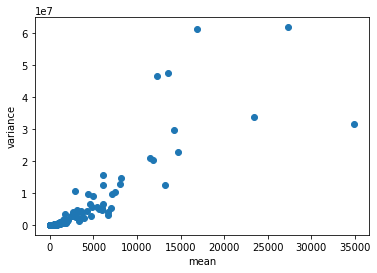

In [26]:
mean_variance_plot(table)

### Log transformation

In [27]:
log_table = table#np.log2(table)

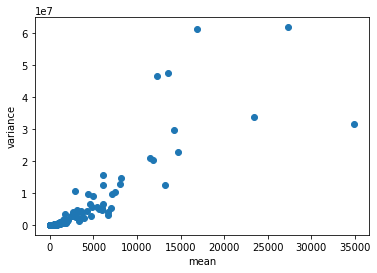

In [28]:
mean_variance_plot(log_table)

### Loess regression

In [29]:
lowess = LowessRegression(sigma=1, span=0.1)

In [30]:
means, variances = get_means_and_variances(log_table)
lowess.fit(means.to_numpy().reshape(-1,1), variances)

LowessRegression(span=0.1)

In [31]:
x_axis = np.linspace(-2, 14, 100)
y_axis = lowess.predict(x_axis.reshape(-1,1))

[]

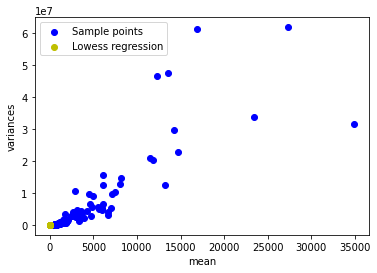

In [32]:
plt.scatter(means, variances, color="b")
plt.scatter(x_axis, y_axis, color="y")
plt.xlabel("mean")
plt.ylabel("variances")
plt.legend(["Sample points", "Lowess regression"])
plt.plot()

In [33]:
adj_var = lowess.predict(means.to_numpy().reshape(-1, 1))

In [34]:
log_table /= np.sqrt(adj_var)

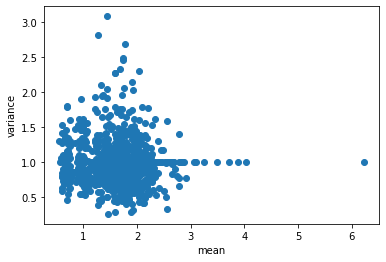

In [35]:
mean_variance_plot(log_table)

### Remove mean

In [36]:
norm_log_table = log_table #- np.mean(log_table)

In [37]:
#norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

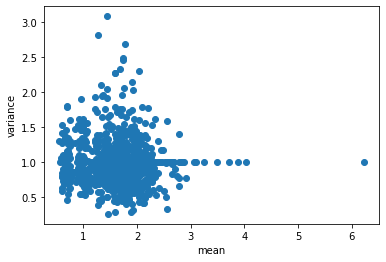

In [38]:
mean_variance_plot(norm_log_table)

### PCA

In [39]:
pca = decomposition.PCA(n_components=10)

In [40]:
pca.fit(norm_log_table)

PCA(n_components=10)

In [41]:
pca.explained_variance_ratio_

array([0.20969092, 0.07421342, 0.06293087, 0.05583117, 0.05394217,
       0.03686956, 0.03366533, 0.02865633, 0.02585703, 0.02536336])

In [42]:
components = pca.transform(norm_log_table)

In [43]:
components.shape

(47, 10)

In [44]:
sum(controls)

19

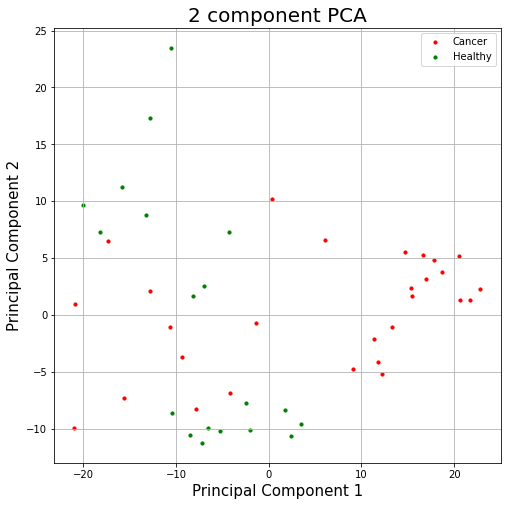

In [45]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [46]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

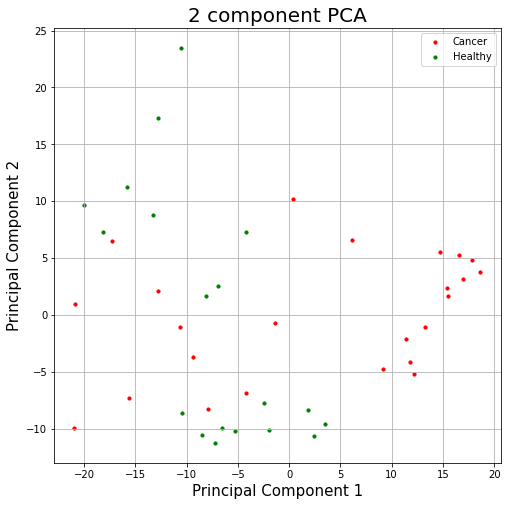

In [47]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Linear regression adjustments

In [48]:
covars = pd.read_csv("../Dataset/Leidinger2011/metadata.csv", index_col=0)

In [49]:
covars = covars.loc[meta]

In [50]:
covars["sex"] = covars["sex"] == "f"

In [51]:
covars = covars.fillna(covars.mean())

In [52]:
linreg = LinearRegression()
linreg.fit(covars, norm_log_table)

LinearRegression()

In [53]:
adj_norm_log_table = norm_log_table #- linreg.predict(covars)

# PCA

In [54]:
pca = decomposition.PCA(n_components=2)

In [55]:
pca.fit(adj_norm_log_table)

PCA(n_components=2)

In [56]:
components = pca.transform(adj_norm_log_table)

In [57]:
components

array([[ -4.18747352,  -6.83786075],
       [ -7.87574587,  -8.28077919],
       [-20.94603427,  -9.92889962],
       [-15.63499129,  -7.29571554],
       [ -7.22518836, -11.26674433],
       [-10.43361283,  -8.65187025],
       [ 22.82453764,   2.29778685],
       [ 21.75684646,   1.33054332],
       [ 11.40433942,  -2.13761001],
       [ 13.24940405,  -1.07234651],
       [ 12.21032758,  -5.22947634],
       [  9.122011  ,  -4.79475633],
       [ 17.85865303,   4.81347947],
       [ 15.46232207,   1.65418158],
       [ 16.59412745,   5.22848621],
       [ 17.00250521,   3.18557505],
       [ 20.52319299,   5.15245287],
       [ 11.76602158,  -4.16304581],
       [ -1.42246911,  -0.70462229],
       [ 14.70259617,   5.5644948 ],
       [  6.09764011,   6.55892438],
       [-12.82900866,   2.10031377],
       [ -6.9322517 ,   2.51515835],
       [-17.28032347,   6.50269887],
       [  0.39927643,  10.19452572],
       [-20.92290638,   1.00202598],
       [ -9.35368921,  -3.7297732 ],
 

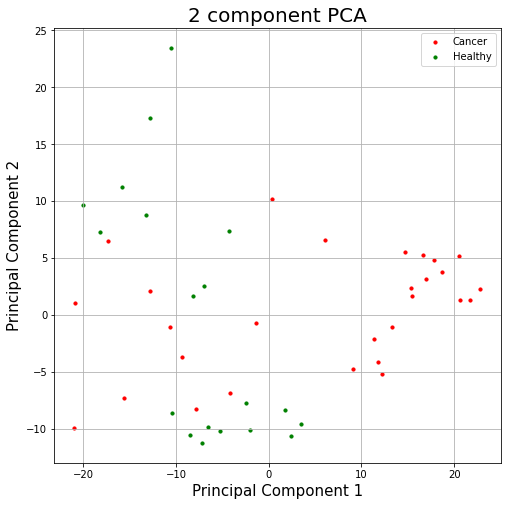

In [58]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [59]:
X_train, X_test, y_train, y_test = train_test_split(adj_norm_log_table, controls, test_size=0.33, random_state=42)

In [60]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


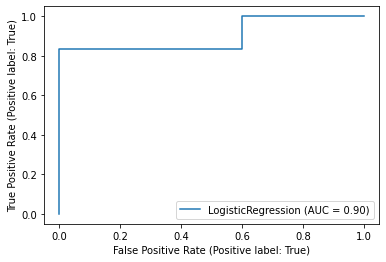

In [61]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [62]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[18:44:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


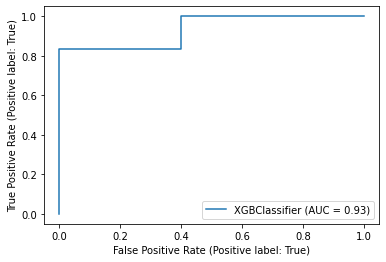

In [63]:
plot_roc_curve(model, X_test, y_test)

### Exporting data

In [64]:
lookup_table = data.gpls["GPL9040"].table

In [65]:
lookup_table = lookup_table.set_index("ID")

In [66]:
mirnas

0        hsa-miR-130b
1         hsa-miR-27b
2      hsa-miR-574-3p
3         hsa-miR-99a
4      hsa-miR-92a-1*
            ...      
858       hsa-miR-943
859     hsa-miR-551b*
860       hsa-miR-380
861       hsa-miR-377
862      hsa-miR-424*
Name: ID_REF, Length: 863, dtype: object

In [67]:
sequences = lookup_table.loc[mirnas]["SEQUENCE"]

In [68]:
sequences = [s.upper() for s in sequences]

In [69]:
sequences[:10]

['CAGUGCAAUGAUGAAAGGGCAU',
 'UUCACAGUGGCUAAGUUCUGC',
 'CACGCUCAUGCACACACCCACA',
 'AACCCGUAGAUCCGAUCUUGUG',
 'AGGUUGGGAUCGGUUGCAAUGCU',
 'UCUUGUGUUCUCUAGAUCAGU',
 'GAUGAUGAUGGCAGCAAAUUCUGAAA',
 'UGCUUCCUUUCAGAGGGU',
 'UAUGGCUUUUCAUUCCUAUGUGA',
 'AUCCUUGCUAUCUGGGUGCUA']

In [70]:
adj_norm_log_table.columns = sequences
adj_norm_log_table = adj_norm_log_table.loc[:,~adj_norm_log_table.columns.duplicated()]
adj_norm_log_table["cancer"] = sick

C:\Users\olefr\AppData\Local\Temp/ipykernel_10192/2574176438.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_norm_log_table["cancer"] = sick


In [71]:
adj_norm_log_table.head()

,CAGUGCAAUGAUGAAAGGGCAU,UUCACAGUGGCUAAGUUCUGC,CACGCUCAUGCACACACCCACA,AACCCGUAGAUCCGAUCUUGUG,AGGUUGGGAUCGGUUGCAAUGCU,UCUUGUGUUCUCUAGAUCAGU,GAUGAUGAUGGCAGCAAAUUCUGAAA,UGCUUCCUUUCAGAGGGU,UAUGGCUUUUCAUUCCUAUGUGA,AUCCUUGCUAUCUGGGUGCUA,...,AAUCACUAACCACACGGCCAGG,UUUGGCAAUGGUAGAACUCACACU,UCUGCAGGGUUUGCUUUGAG,AGGCAUUGACUUCUCACUAGCU,CUGACUGUUGCCGUCCUCCAG,GAAAUCAAGCGUGGGUGAGACC,UAUGUAAUAUGGUCCACAUCUU,AUCACACAAAGGCAACUUUUGU,CAAAACGUGAGGCGCUGCUAU,cancer
VALUE,4.200511,2.540052,0.738573,1.579269,0.536967,0.883922,1.339055,0.484611,0.029135,0.162943,...,0.887111,5.363658,4.449894,2.519719,1.271089,0.964988,1.512758,1.870301,2.646504,True
VALUE,1.364906,1.619220,1.374093,0.765230,0.726574,0.033525,1.806065,0.123510,0.029135,0.661438,...,1.897932,3.851196,2.321423,2.991753,2.106522,1.234746,0.442238,2.192883,1.825581,True
VALUE,1.298235,1.157645,1.908025,0.635348,0.178989,0.732825,7.279936,0.033470,0.029135,0.415642,...,1.646159,2.582479,1.192569,1.889458,0.385683,2.220569,2.060218,3.328975,1.283933,True
VALUE,3.496637,1.362480,1.329206,0.773916,1.249889,0.719604,2.533499,0.942823,0.029135,0.526112,...,1.950152,2.582479,3.661861,2.668016,1.252510,1.406361,0.127334,2.869632,2.305494,True
VALUE,2.704301,0.817488,2.320950,0.539384,0.089494,1.262611,1.573812,0.618492,0.096842,0.923113,...,2.254766,3.520721,3.967817,3.328730,0.856576,1.166210,1.019434,2.218084,1.847629,False


In [72]:
adj_norm_log_table.to_csv("../TransformedData/Leidinger2011_raw.csv", index=False)